# Benchmarking Optimizers

This notebook compares a set of modern optimizers on several synthetic matrix objectives. It logs and visualizes loss curves to provide a practical comparison across optimizers.

### Optimization tasks covered
- **Linear regression with SPD preconditioning**: $L(X) = (X − X_*)^T H (X − X_*)$. Function: `linear_regression_loss(X, X_star, H)`.
- **Low-rank matrix completion (masked Frobenius)**: $L(X, Y) = ||A ⊙ (X Y^T − M_*)||_F^2 / ||A||_F^2$. Function: `lowrank_matrix_completion_loss(X, Y, A_mask, M_star)`.
- **Low-rank matrix completion with nuclear-norm residual**: $L(X, Y) = ||A ⊙ (X Y^T − M_*)||_{\mathrm{nuc}}^2 / ||A||_{\mathrm{nuc}}^2$. Function: `lowrank_matrix_completion_loss_with_nuc_norm(X, Y, A_mask, M_star)`.
- **Matrix quadratic regression**: $L(X) = \frac{1}{2}||A X B − C||_F^2$. Function: `matrix_quadratic_regression_loss(X, A, B, C)`.

### Optimizers implemented
- **SOAP**: Adam-style updates in the eigen-bases of Shampoo-like preconditioners with periodic preconditioning and dimension merging options. Class: `optimizers.soap.SOAP`.
- **Shampoo (full)**: Two-sided matrix preconditioning with momentum. Class: `optimizers.optimizers.Shampoo`.
- **One-Sided Shampoo**: Shape-aware left/right preconditioning. Class: `optimizers.optimizers.OneSidedShampoo`.
- **Muon family (momentum orthogonalized by Newton–Schulz)**: An optimizer for hidden layers in neural networks.
  - Single-device: `optimizers.muon.SingleDeviceMuon`
  - Distributed: `optimizers.muon.Muon`
  - With auxiliary Adam for incompatible params: `optimizers.muon.MuonWithAuxAdam`, `optimizers.muon.SingleDeviceMuonWithAuxAdam`
- **Sign Gradient Descent**: Uses `sign(grad)` for updates. Class: `optimizers.optimizers.SignGradientDescent`.
- **Normalized Gradient Descent**: L∞-normalized gradients with momentum. Class: `optimizers.optimizers.NormalizedGradientDescent`.
- **Adam**: A standard first-order optimizer that computes adaptive learning rates for each parameter. Implemented as `torch.optim.Adam`.
- **AdamW**: A variant of Adam that fixes weight decay regularization. Implemented as `torch.optim.AdamW`.
- **Adagrad**: An optimizer that adapts the learning rate to parameters, performing smaller updates for more frequent features. Implemented as `torch.optim.Adagrad`.

### References
The implementations of SOAP and Muon are based on their official repositories:
- **SOAP**: [https://github.com/nikhilvyas/SOAP](https://github.com/nikhilvyas/SOAP)
- **Muon**: [https://github.com/KellerJordan/Muon](https://github.com/KellerJordan/Muon)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from optimizers.muon import SingleDeviceMuon
from optimizers.soap import SOAP
from optimizers import Shampoo, OneSidedShampoo, SignGradientDescent # Assuming optimizers.py is in the same directory
from objective_functions import linear_regression_loss, lowrank_matrix_completion_loss, lowrank_matrix_completion_loss_with_nuc_norm, matrix_quadratic_regression_loss # Assuming objective_functions.py is in the same directory

# Global settings
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda') # Use 'cuda' if you have a GPU and want to use it
print(f"Using device: {device}")
dtype = torch.float32

# Common optimizer parameters
steps = 3000 # Default steps, can be overridden per test

Using device: cuda


### Matrix Linear Regression Problem

In [ ]:
d = 1000

# Construct H with specified eigenvalues
sigma = torch.ones(d, device=device, dtype=dtype)
for i in range(10, d):
    sigma[i] = 1.0 / ((i - 10 + 1) ** 2)
Q, _ = torch.linalg.qr(torch.randn(d, d, device=device, dtype=dtype))
H = Q @ torch.diag(sigma) @ Q.t()
H = H.to(device)

# Ground truth
X_star = torch.randn(d, d, device=device) / np.sqrt(d)

def get_X0_linear_regression():
    return torch.zeros((d, d), device=device, dtype=dtype, requires_grad=True)

linear_regression_steps = 5000 # Specific steps for this benchmark

lr_muon = 5e-3
beta_muon = 0.95
lr_decay_muon = 0.99 # For Muon with LR decay
weight_decay_muon = 0.01

lr_adam = 1e-3
beta_adam = 0.9
lr_decay_adam = 0.99 # For Adam with LR decay

lr_adamW = 1e-3
beta_adamW = 0.9
lr_decay_adamW = 0.99 # For AdamW with LR decay
weight_decay_adamW = 0.01 # For Adam with weight decay

lr_adagrad = 0.1
beta_adagrad = 0.9 # Adagrad momentum (note: PyTorch's Adagrad doesn't have a direct momentum param)
lr_decay_adagrad = 0.99 # For Adagrad with LR decay
weight_decay_adagrad = 0.01 # For Adagrad with weight decay

lr_shampoo = 0.1
beta_shampoo = 0.9
lr_decay_shampoo = 0.99 # For Shampoo with LR decay
weight_decay_shampoo = 0.01

lr_sgd = 1e-3 # Learning rate for Sign Gradient Descent
lr_decay_sgd = 0.99 # For Sign Gradient Descent with LR decay

lr_soap = 3e-3
beta_soap_1 = 0.95
beta_soap_2 = 0.95
lr_decay_soap = 0.99 # For SOAP with LR decay
weight_decay_soap = 0.01

In [ ]:
# Muon (NS)
X_muon_lr = get_X0_linear_regression()
optimizer_muon_lr = SingleDeviceMuon([X_muon_lr], lr=lr_muon, momentum=beta_muon)
muon_losses_lr = []

print("\nRunning Muon for Linear Regression...")
for step in range(linear_regression_steps):
    optimizer_muon_lr.zero_grad()
    loss = linear_regression_loss(X_muon_lr, X_star, H)
    loss.backward()
    optimizer_muon_lr.step()
    muon_losses_lr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Muon] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}")

# Muon (NS) with LR decay and weight decay
X_muon_lr_decay = get_X0_linear_regression()
optimizer_muon_lr_decay = SingleDeviceMuon([X_muon_lr_decay], lr=lr_muon, momentum=beta_muon, weight_decay=weight_decay_muon)
scheduler_muon_lr_decay = torch.optim.lr_scheduler.StepLR(optimizer_muon_lr_decay, step_size=25, gamma=lr_decay_muon)
muon_losses_lr_decay = []

print("\nRunning Muon (NS) with LR decay for Linear Regression...")
for step in range(linear_regression_steps):
    optimizer_muon_lr_decay.zero_grad()
    loss = linear_regression_loss(X_muon_lr_decay, X_star, H)
    loss.backward()
    optimizer_muon_lr_decay.step()
    scheduler_muon_lr_decay.step()
    muon_losses_lr_decay.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Muon lr↓/wd] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}, lr: {scheduler_muon_lr_decay.get_last_lr()[0]:.4e}")

# Adam
X_adam_lr = get_X0_linear_regression()
optimizer_adam_lr = torch.optim.Adam([X_adam_lr], lr=lr_adam, betas=(beta_adam, 0.999))
adam_losses_lr = []

print("\nRunning Adam for Linear Regression...")

for step in range(linear_regression_steps):
    optimizer_adam_lr.zero_grad()
    loss = linear_regression_loss(X_adam_lr, X_star, H)
    loss.backward()
    optimizer_adam_lr.step()
    adam_losses_lr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adam] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}")

# Adam (lr decay)
X_adam_decay_lr = get_X0_linear_regression()
optimizer_adam_decay_lr = torch.optim.Adam([X_adam_decay_lr], lr=lr_adam, betas=(beta_adam, 0.999))
scheduler_adam_decay_lr = torch.optim.lr_scheduler.StepLR(optimizer_adam_decay_lr, step_size=25, gamma=lr_decay_adam)
adam_decay_losses_lr = []

print("\nRunning Adam (lr decay) for Linear Regression...")

for step in range(linear_regression_steps):
    optimizer_adam_decay_lr.zero_grad()
    loss = linear_regression_loss(X_adam_decay_lr, X_star, H)
    loss.backward()
    optimizer_adam_decay_lr.step()
    scheduler_adam_decay_lr.step()
    adam_decay_losses_lr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adam lr↓] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}, lr: {scheduler_adam_decay_lr.get_last_lr()[0]:.4e}")

# AdamW
X_adamW_lr_decay = get_X0_linear_regression()
optimizer_adamW_lr_decay = torch.optim.AdamW([X_adamW_lr_decay], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW)
adamW_losses_lr = []

print("\nRunning AdamW for Linear Regression...")
for step in range(linear_regression_steps):
    optimizer_adamW_lr_decay.zero_grad()
    loss = linear_regression_loss(X_adamW_lr_decay, X_star, H)
    loss.backward()
    optimizer_adamW_lr_decay.step()
    adamW_losses_lr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[AdamW] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}")

# AdamW (lr decay and weight decay)
X_adamW_lr_decay = get_X0_linear_regression()
optimizer_adamW_lr_decay = torch.optim.AdamW([X_adamW_lr_decay], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW)
scheduler_adamW_lr_decay = torch.optim.lr_scheduler.StepLR(optimizer_adamW_lr_decay, step_size=25, gamma=lr_decay_adamW)
adamW_losses_lr_decay = []

print("\nRunning AdamW (lr decay and weight decay) for Linear Regression...")
for step in range(linear_regression_steps):
    optimizer_adamW_lr_decay.zero_grad()
    loss = linear_regression_loss(X_adamW_lr_decay, X_star, H)
    loss.backward()
    optimizer_adamW_lr_decay.step()
    scheduler_adamW_lr_decay.step()
    adamW_losses_lr_decay.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[AdamW lr↓/wd] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}, lr: {scheduler_adamW_lr_decay.get_last_lr()[0]:.4e}")

# Adagrad
X_adagrad_lr = get_X0_linear_regression()
optimizer_adagrad_lr = torch.optim.Adagrad([X_adagrad_lr], lr=lr_adagrad, eps=1e-8) # Added eps for stability
adagrad_losses_lr = []

print("\nRunning Adagrad for Linear Regression...")

for step in range(linear_regression_steps):
    optimizer_adagrad_lr.zero_grad()
    loss = linear_regression_loss(X_adagrad_lr, X_star, H)
    loss.backward()
    optimizer_adagrad_lr.step()
    adagrad_losses_lr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adagrad] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}")


# Adagrad (lr decay)
X_adagrad_lr_decay = get_X0_linear_regression()
optimizer_adagrad_lr_decay = torch.optim.Adagrad([X_adagrad_lr_decay], lr=lr_adagrad, eps=1e-8) # Added eps for stability
scheduler_adagrad_lr_decay = torch.optim.lr_scheduler.StepLR(optimizer_adagrad_lr_decay, step_size=25, gamma=lr_decay_adagrad)
adagrad_losses_lr_decay = []

print("\nRunning Adagrad (lr decay) for Linear Regression...")

for step in range(linear_regression_steps):
    optimizer_adagrad_lr_decay.zero_grad()
    loss = linear_regression_loss(X_adagrad_lr_decay, X_star, H)
    loss.backward()
    optimizer_adagrad_lr_decay.step()
    scheduler_adagrad_lr_decay.step()
    adagrad_losses_lr_decay.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adagrad lr↓] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}, lr: {scheduler_adagrad_lr_decay.get_last_lr()[0]:.4e}")


# Two-sided Shampoo
X_shampoo_lr = get_X0_linear_regression()
optimizer_shampoo_lr = Shampoo([X_shampoo_lr], lr=lr_shampoo, momentum=beta_shampoo)
shampoo_losses_lr = []

print("\nRunning Two-sided Shampoo for Linear Regression...")

for step in range(linear_regression_steps):
    optimizer_shampoo_lr.zero_grad()
    loss = linear_regression_loss(X_shampoo_lr, X_star, H)
    loss.backward()
    optimizer_shampoo_lr.step()
    shampoo_losses_lr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Shampoo] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}")

# One-sided Shampoo
X_onesided_shampoo_lr = get_X0_linear_regression()
optimizer_onesided_shampoo_lr = OneSidedShampoo([X_onesided_shampoo_lr], lr=lr_shampoo, momentum=beta_shampoo)
onesided_shampoo_losses_lr = []

print("\nRunning One-sided Shampoo for Linear Regression...")

for step in range(linear_regression_steps):
    optimizer_onesided_shampoo_lr.zero_grad()
    loss = linear_regression_loss(X_onesided_shampoo_lr, X_star, H)
    loss.backward()
    optimizer_onesided_shampoo_lr.step()
    onesided_shampoo_losses_lr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[One-sided Shampoo] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}")

# Sign Gradient Descent
X_sgd_lr = get_X0_linear_regression()
optimizer_sgd_lr = SignGradientDescent([X_sgd_lr], lr=lr_sgd)
sgd_losses_lr = []

print("\nRunning Sign Gradient Descent for Linear Regression...")
for step in range(linear_regression_steps):
    optimizer_sgd_lr.zero_grad()
    loss = linear_regression_loss(X_sgd_lr, X_star, H)
    loss.backward()
    optimizer_sgd_lr.step()
    sgd_losses_lr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SGD] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}")
        
# Sign Gradient Descent (lr decay)
X_sgd_lr_decay = get_X0_linear_regression()
optimizer_sgd_lr_decay = SignGradientDescent([X_sgd_lr_decay], lr=lr_sgd)
scheduler_sgd_lr_decay = torch.optim.lr_scheduler.StepLR(optimizer_sgd_lr_decay, step_size=25, gamma=lr_decay_sgd)
sgd_losses_lr_decay = []

print("\nRunning Sign Gradient Descent (lr decay) for Linear Regression...")
for step in range(linear_regression_steps):
    optimizer_sgd_lr_decay.zero_grad()
    loss = linear_regression_loss(X_sgd_lr_decay, X_star, H)
    loss.backward()
    optimizer_sgd_lr_decay.step()
    scheduler_sgd_lr_decay.step()
    sgd_losses_lr_decay.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SGD lr↓] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}, lr: {scheduler_sgd_lr_decay.get_last_lr()[0]:.4e}")
        
# SOAP
X_soap_lr = get_X0_linear_regression()
optimizer_soap_lr = SOAP([X_soap_lr], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=weight_decay_soap)
soap_losses_lr = []

print("\nRunning SOAP for Linear Regression...")
for step in range(linear_regression_steps):
    optimizer_soap_lr.zero_grad()
    loss = linear_regression_loss(X_soap_lr, X_star, H)
    loss.backward()
    optimizer_soap_lr.step()
    soap_losses_lr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SOAP] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}")
        
# SOAP (lr decay and weight decay)
X_soap_lr_decay = get_X0_linear_regression()
optimizer_soap_lr_decay = SOAP([X_soap_lr_decay], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=weight_decay_soap)
scheduler_soap_lr_decay = torch.optim.lr_scheduler.StepLR(optimizer_soap_lr_decay, step_size=25, gamma=lr_decay_soap)
soap_losses_lr_decay = []

print("\nRunning SOAP (lr decay and weight decay) for Linear Regression...")
for step in range(linear_regression_steps):
    optimizer_soap_lr_decay.zero_grad()
    loss = linear_regression_loss(X_soap_lr_decay, X_star, H)
    loss.backward()
    optimizer_soap_lr_decay.step()
    scheduler_soap_lr_decay.step()
    soap_losses_lr_decay.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SOAP lr↓] Step {step+1}/{linear_regression_steps}, Loss: {loss.item():.4e}, lr: {scheduler_soap_lr_decay.get_last_lr()[0]:.4e}")



Running Muon for Linear Regression...
[Muon] Step 100/5000, Loss: 2.8678e+00
[Muon] Step 200/5000, Loss: 5.1136e-02
[Muon] Step 300/5000, Loss: 9.5966e-03
[Muon] Step 400/5000, Loss: 2.0600e-03
[Muon] Step 500/5000, Loss: 5.7742e-04
[Muon] Step 600/5000, Loss: 1.0113e-04
[Muon] Step 700/5000, Loss: 3.5292e-05
[Muon] Step 800/5000, Loss: 4.0741e-05
[Muon] Step 900/5000, Loss: 3.8958e-05
[Muon] Step 1000/5000, Loss: 4.6167e-05
[Muon] Step 1100/5000, Loss: 1.6215e-04
[Muon] Step 1200/5000, Loss: 1.9776e-04
[Muon] Step 1300/5000, Loss: 2.4900e-04
[Muon] Step 1400/5000, Loss: 2.3678e-04
[Muon] Step 1500/5000, Loss: 2.0160e-04
[Muon] Step 1600/5000, Loss: 1.8038e-04
[Muon] Step 1700/5000, Loss: 2.6095e-04
[Muon] Step 1800/5000, Loss: 1.1975e-04
[Muon] Step 1900/5000, Loss: 1.6845e-04
[Muon] Step 2000/5000, Loss: 1.9503e-04
[Muon] Step 2100/5000, Loss: 1.1179e-04
[Muon] Step 2200/5000, Loss: 5.4046e-05
[Muon] Step 2300/5000, Loss: 6.2001e-05
[Muon] Step 2400/5000, Loss: 1.0544e-04
[Muon] Ste

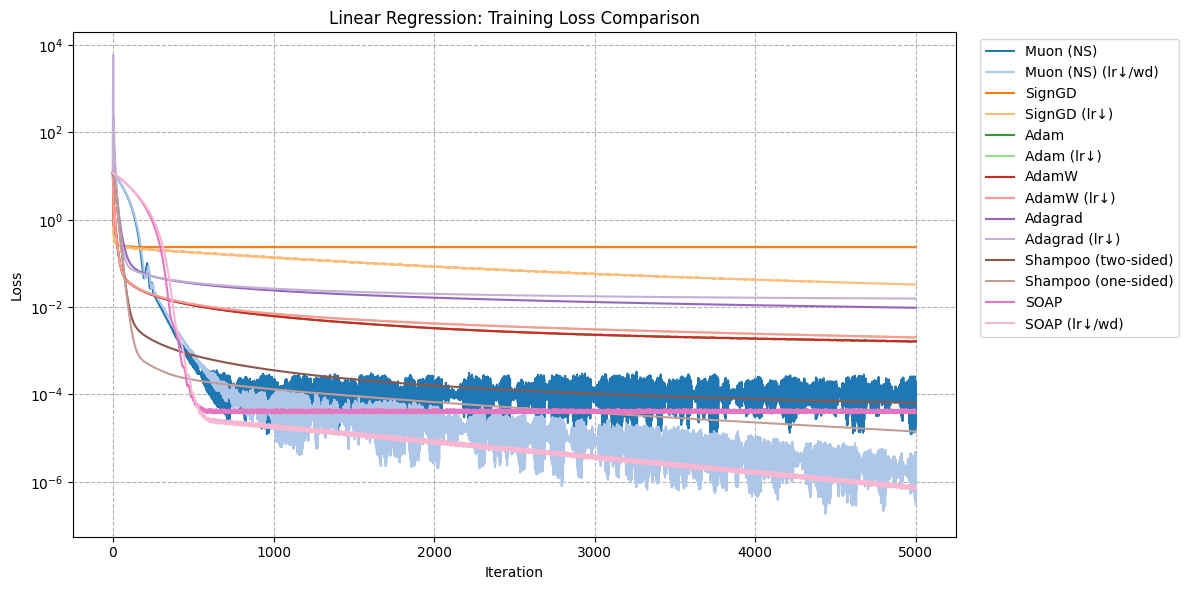

In [ ]:
plt.figure(figsize=(12, 6)) 
colors = plt.get_cmap('tab20').colors
cycler = cycle(colors)
plt.rc('axes', prop_cycle=(plt.cycler('color', colors)))
plt.semilogy(muon_losses_lr, label='Muon (NS)')
plt.semilogy(muon_losses_lr_decay, label='Muon (NS) (lr↓/wd)')
plt.semilogy(sgd_losses_lr, label='SignGD')
plt.semilogy(sgd_losses_lr_decay, label='SignGD (lr↓)')
plt.semilogy(adam_losses_lr, label='Adam')
plt.semilogy(adam_decay_losses_lr, label='Adam (lr↓)')
plt.semilogy(adamW_losses_lr, label='AdamW')
plt.semilogy(adamW_losses_lr_decay, label='AdamW (lr↓)')
plt.semilogy(adagrad_losses_lr, label='Adagrad')
plt.semilogy(adagrad_losses_lr_decay, label='Adagrad (lr↓)')
plt.semilogy(shampoo_losses_lr, label='Shampoo (two-sided)')
plt.semilogy(onesided_shampoo_losses_lr, label='Shampoo (one-sided)')
plt.semilogy(soap_losses_lr, label='SOAP')
plt.semilogy(soap_losses_lr_decay, label='SOAP (lr↓/wd)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Linear Regression: Training Loss Comparison')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left') 
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.savefig('linear_regression_loss_comparison_2.png', bbox_inches='tight')  
plt.show()

### Lowrank Matrix Completion Problem with respect to Frobenius Norm

In [ ]:
m, n, r = 500, 250, 5
lowrank_mc_steps = 3000 # Specific steps for this benchmark

# Generate mask A
A_mask = (torch.rand(m, n, device=device) < 0.3).float()

# Generate ground truth M_star = U V^T
U = torch.randn(m, r, device=device)
V = torch.randn(n, r, device=device)
M_star = U @ V.t()

def get_XY0_lowrank_mc():
    X0 = (2 * torch.rand(m, r, device=device) - 1).requires_grad_()
    Y0 = (2 * torch.rand(n, r, device=device) - 1).requires_grad_()
    return X0, Y0

lr_muon = 1e-2
beta_muon = 0.95
lr_decay_muon = 0.95 # For Muon with LR decay
weight_decay_muon = 0.01

lr_adam = 5e-2
beta_adam = 0.9
lr_decay_adam = 0.95 # For Adam with LR decay

lr_adamW = 5e-2
beta_adamW = 0.9
lr_decay_adamW = 0.95 # For AdamW with LR decay
weight_decay_adamW = 0.01 # For Adam with weight decay

lr_adagrad = 1.0
beta_adagrad = 0.9 # Adagrad momentum (note: PyTorch's Adagrad doesn't have a direct momentum param)
lr_decay_adagrad = 0.95 # For Adagrad with LR decay
weight_decay_adagrad = 0.01 # For Adagrad with weight decay

lr_shampoo = 1.0
beta_shampoo = 0.9
lr_decay_shampoo = 0.95 # For Shampoo with LR decay
weight_decay_shampoo = 0.01

lr_sgd = 5e-2 # Learning rate for Sign Gradient Descent
lr_decay_sgd = 0.95 # For Sign Gradient Descent with LR decay

lr_soap = 5e-2
beta_soap_1 = 0.95
beta_soap_2 = 0.95
lr_decay_soap = 0.95 # For SOAP with LR decay
weight_decay_soap = 0.01

In [ ]:
# Muon (NS)
X_muon_mc, Y_muon_mc = get_XY0_lowrank_mc()
optimizer_muon_X_mc = SingleDeviceMuon([X_muon_mc], lr=lr_muon, momentum=beta_muon)
optimizer_muon_Y_mc = SingleDeviceMuon([Y_muon_mc], lr=lr_muon, momentum=beta_muon)
muon_losses_mc = []

print("\nRunning Muon for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    # Alternate optimization of X and Y
    optimizer_muon_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_muon_mc, Y_muon_mc, A_mask, M_star)
    loss.backward()
    optimizer_muon_X_mc.step()

    optimizer_muon_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_muon_mc, Y_muon_mc, A_mask, M_star) # Recalculate loss for Y's gradient
    loss.backward()
    optimizer_muon_Y_mc.step()

    muon_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Muon] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")

# Muon (NS) with LR decay and weight decay
X_muon_mc_decay, Y_muon_mc_decay = get_XY0_lowrank_mc()
optimizer_muon_X_mc_decay = SingleDeviceMuon([X_muon_mc_decay], lr=lr_muon, momentum=beta_muon, weight_decay=weight_decay_muon)
optimizer_muon_Y_mc_decay = SingleDeviceMuon([Y_muon_mc_decay], lr=lr_muon, momentum=beta_muon, weight_decay=weight_decay_muon)
muon_losses_mc_decay = []

print("\nRunning Muon (NS) with LR decay and weight decay for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_muon_X_mc_decay.zero_grad()
    loss = lowrank_matrix_completion_loss(X_muon_mc_decay, Y_muon_mc_decay, A_mask, M_star)
    loss.backward()
    optimizer_muon_X_mc_decay.step()

    optimizer_muon_Y_mc_decay.zero_grad()
    loss = lowrank_matrix_completion_loss(X_muon_mc_decay, Y_muon_mc_decay, A_mask, M_star)
    loss.backward()
    optimizer_muon_Y_mc_decay.step()

    muon_losses_mc_decay.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Muon lr↓/wd] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")

# Adam (fixed lr)
X_adam_mc, Y_adam_mc = get_XY0_lowrank_mc()
adam_losses_mc = []
optimizer_adam_X_mc = torch.optim.Adam([X_adam_mc], lr=lr_adam, betas=(beta_adam, 0.999), eps=1e-8)
optimizer_adam_Y_mc = torch.optim.Adam([Y_adam_mc], lr=lr_adam, betas=(beta_adam, 0.999), eps=1e-8)

print("\nRunning Adam for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adam_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adam_mc, Y_adam_mc, A_mask, M_star)
    loss.backward()
    optimizer_adam_X_mc.step()

    optimizer_adam_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adam_mc, Y_adam_mc, A_mask, M_star)
    loss.backward()
    optimizer_adam_Y_mc.step()

    adam_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adam] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")

# Adam (lr decay)
X_adam_decay_mc, Y_adam_decay_mc = get_XY0_lowrank_mc()
adam_decay_losses_mc = []
optimizer_adam_decay_X_mc = torch.optim.Adam([X_adam_decay_mc], lr=lr_adam, betas=(beta_adam, 0.999), eps=1e-8)
optimizer_adam_decay_Y_mc = torch.optim.Adam([Y_adam_decay_mc], lr=lr_adam, betas=(beta_adam, 0.999), eps=1e-8)
scheduler_X_mc = torch.optim.lr_scheduler.StepLR(optimizer_adam_decay_X_mc, step_size=25, gamma=lr_decay_adam)
scheduler_Y_mc = torch.optim.lr_scheduler.StepLR(optimizer_adam_decay_Y_mc, step_size=25, gamma=lr_decay_adam)

print("\nRunning Adam (lr decay) for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adam_decay_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adam_decay_mc, Y_adam_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adam_decay_X_mc.step()
    scheduler_X_mc.step()

    optimizer_adam_decay_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adam_decay_mc, Y_adam_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adam_decay_Y_mc.step()
    scheduler_Y_mc.step()

    adam_decay_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adam lr↓] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}, lr: {scheduler_X_mc.get_last_lr()[0]:.4e}")

# AdamW
X_adamw_mc, Y_adamw_mc = get_XY0_lowrank_mc()
adamw_losses_mc = []
optimizer_adamw_X_mc = torch.optim.AdamW([X_adamw_mc], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW, eps=1e-8)
optimizer_adamw_Y_mc = torch.optim.AdamW([Y_adamw_mc], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW, eps=1e-8)

print("\nRunning AdamW for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adamw_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adamw_mc, Y_adamw_mc, A_mask, M_star)
    loss.backward()
    optimizer_adamw_X_mc.step()

    optimizer_adamw_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adamw_mc, Y_adamw_mc, A_mask, M_star)
    loss.backward()
    optimizer_adamw_Y_mc.step()

    adamw_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[AdamW] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")

# AdamW (lr decay)
X_adamw_decay_mc, Y_adamw_decay_mc = get_XY0_lowrank_mc()
adamw_decay_losses_mc = []
optimizer_adamw_decay_X_mc = torch.optim.AdamW([X_adamw_decay_mc], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW, eps=1e-8)
optimizer_adamw_decay_Y_mc = torch.optim.AdamW([Y_adamw_decay_mc], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW, eps=1e-8)
scheduler_X_mc = torch.optim.lr_scheduler.StepLR(optimizer_adamw_decay_X_mc, step_size=25, gamma=lr_decay_adamW)
scheduler_Y_mc = torch.optim.lr_scheduler.StepLR(optimizer_adamw_decay_Y_mc, step_size=25, gamma=lr_decay_adamW)

print("\nRunning AdamW (lr decay) for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adamw_decay_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adamw_decay_mc, Y_adamw_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adamw_decay_X_mc.step()
    scheduler_X_mc.step()

    optimizer_adamw_decay_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adamw_decay_mc, Y_adamw_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adamw_decay_Y_mc.step()
    scheduler_Y_mc.step()

    adamw_decay_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[AdamW lr↓] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}, lr: {scheduler_X_mc.get_last_lr()[0]:.4e}")

# Sign Gradient Descent
X_sgd_mc, Y_sgd_mc = get_XY0_lowrank_mc()
optimizer_sgd_X_mc = SignGradientDescent([X_sgd_mc], lr=lr_sgd)
optimizer_sgd_Y_mc = SignGradientDescent([Y_sgd_mc], lr=lr_sgd)
sgd_losses_mc = []

print("\nRunning Sign Gradient Descent for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_sgd_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_sgd_mc, Y_sgd_mc, A_mask, M_star)
    loss.backward()
    optimizer_sgd_X_mc.step()

    optimizer_sgd_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_sgd_mc, Y_sgd_mc, A_mask, M_star)
    loss.backward()
    optimizer_sgd_Y_mc.step()

    sgd_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SGD] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")
        
# Sign Gradient Descent (lr decay)
X_sgd_decay_mc, Y_sgd_decay_mc = get_XY0_lowrank_mc()
optimizer_sgd_decay_X_mc = SignGradientDescent([X_sgd_decay_mc], lr=lr_sgd)
optimizer_sgd_decay_Y_mc = SignGradientDescent([Y_sgd_decay_mc], lr=lr_sgd)
scheduler_X_mc = torch.optim.lr_scheduler.StepLR(optimizer_sgd_decay_X_mc, step_size=25, gamma=lr_decay_sgd)
scheduler_Y_mc = torch.optim.lr_scheduler.StepLR(optimizer_sgd_decay_Y_mc, step_size=25, gamma=lr_decay_sgd)
sgd_decay_losses_mc = []

print("\nRunning Sign Gradient Descent (lr decay) for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_sgd_decay_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_sgd_decay_mc, Y_sgd_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_sgd_decay_X_mc.step()
    scheduler_X_mc.step()

    optimizer_sgd_decay_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_sgd_decay_mc, Y_sgd_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_sgd_decay_Y_mc.step()
    scheduler_Y_mc.step()

    sgd_decay_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SGD lr↓] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}, lr: {scheduler_X_mc.get_last_lr()[0]:.4e}")

# Adagrad
X_adagrad_mc, Y_adagrad_mc = get_XY0_lowrank_mc()
optimizer_adagrad_X_mc = torch.optim.Adagrad([X_adagrad_mc], lr=lr_adagrad, eps=1e-8) # Added eps for stability
optimizer_adagrad_Y_mc = torch.optim.Adagrad([Y_adagrad_mc], lr=lr_adagrad, eps=1e-8) # Added eps for stability
adagrad_losses_mc = []

print("\nRunning Adagrad for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adagrad_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adagrad_mc, Y_adagrad_mc, A_mask, M_star)
    loss.backward()
    optimizer_adagrad_X_mc.step()

    optimizer_adagrad_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adagrad_mc, Y_adagrad_mc, A_mask, M_star)
    loss.backward()
    optimizer_adagrad_Y_mc.step()

    adagrad_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adagrad] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")
        
# Adagrad (lr decay)
X_adagrad_decay_mc, Y_adagrad_decay_mc = get_XY0_lowrank_mc()
optimizer_adagrad_decay_X_mc = torch.optim.Adagrad([X_adagrad_decay_mc], lr=lr_adagrad, eps=1e-8) # Added eps for stability
optimizer_adagrad_decay_Y_mc = torch.optim.Adagrad([Y_adagrad_decay_mc], lr=lr_adagrad, eps=1e-8) # Added eps for stability
scheduler_X_mc = torch.optim.lr_scheduler.StepLR(optimizer_adagrad_decay_X_mc, step_size=25, gamma=lr_decay_adagrad)
scheduler_Y_mc = torch.optim.lr_scheduler.StepLR(optimizer_adagrad_decay_Y_mc, step_size=25, gamma=lr_decay_adagrad)
adagrad_decay_losses_mc = []

print("\nRunning Adagrad (lr decay) for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adagrad_decay_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adagrad_decay_mc, Y_adagrad_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adagrad_decay_X_mc.step()
    scheduler_X_mc.step()

    optimizer_adagrad_decay_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_adagrad_decay_mc, Y_adagrad_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adagrad_decay_Y_mc.step()
    scheduler_Y_mc.step()

    adagrad_decay_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adagrad lr↓] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}, lr: {scheduler_X_mc.get_last_lr()[0]:.4e}")
        
# Two-sided Shampoo
X_shampoo_mc, Y_shampoo_mc = get_XY0_lowrank_mc()
optimizer_shampoo_X_mc = Shampoo([X_shampoo_mc], lr=lr_shampoo, momentum=beta_shampoo)
optimizer_shampoo_Y_mc = Shampoo([Y_shampoo_mc], lr=lr_shampoo, momentum=beta_shampoo)
shampoo_losses_mc = []

print("\nRunning Shampoo for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_shampoo_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_shampoo_mc, Y_shampoo_mc, A_mask, M_star)
    loss.backward()
    optimizer_shampoo_X_mc.step()

    optimizer_shampoo_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_shampoo_mc, Y_shampoo_mc, A_mask, M_star)
    loss.backward()
    optimizer_shampoo_Y_mc.step()

    shampoo_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Shampoo] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")
        
# One-sided Shampoo
X_onesided_shampoo_mc, Y_onesided_shampoo_mc = get_XY0_lowrank_mc()
optimizer_onesided_shampoo_X_mc = OneSidedShampoo([X_onesided_shampoo_mc], lr=lr_shampoo, momentum=beta_shampoo)
optimizer_onesided_shampoo_Y_mc = OneSidedShampoo([Y_onesided_shampoo_mc], lr=lr_shampoo, momentum=beta_shampoo)
onesided_shampoo_losses_mc = []

print("\nRunning One-sided Shampoo for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_onesided_shampoo_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_onesided_shampoo_mc, Y_onesided_shampoo_mc, A_mask, M_star)
    loss.backward()
    optimizer_onesided_shampoo_X_mc.step()

    optimizer_onesided_shampoo_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_onesided_shampoo_mc, Y_onesided_shampoo_mc, A_mask, M_star)
    loss.backward()
    optimizer_onesided_shampoo_Y_mc.step()

    onesided_shampoo_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[One-sided Shampoo] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")

# SOAP
X_soap_mc, Y_soap_mc = get_XY0_lowrank_mc()
optimizer_soap_X_mc = SOAP([X_soap_mc], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=0.01)
optimizer_soap_Y_mc = SOAP([Y_soap_mc], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=0.01)
soap_losses_mc = []

print("\nRunning SOAP for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_soap_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_soap_mc, Y_soap_mc, A_mask, M_star)
    loss.backward()
    optimizer_soap_X_mc.step()

    optimizer_soap_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_soap_mc, Y_soap_mc, A_mask, M_star)
    loss.backward()
    optimizer_soap_Y_mc.step()

    soap_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SOAP] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")
        
# SOAP (lr decay)
X_soap_decay_mc, Y_soap_decay_mc = get_XY0_lowrank_mc()
optimizer_soap_decay_X_mc = SOAP([X_soap_decay_mc], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=0.01)
optimizer_soap_decay_Y_mc = SOAP([Y_soap_decay_mc], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=0.01)
scheduler_X_mc = torch.optim.lr_scheduler.StepLR(optimizer_soap_decay_X_mc, step_size=25, gamma=lr_decay_soap)
scheduler_Y_mc = torch.optim.lr_scheduler.StepLR(optimizer_soap_decay_Y_mc, step_size=25, gamma=lr_decay_soap)
soap_decay_losses_mc = []

print("\nRunning SOAP (lr decay) for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_soap_decay_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_soap_decay_mc, Y_soap_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_soap_decay_X_mc.step()
    scheduler_X_mc.step()

    optimizer_soap_decay_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss(X_soap_decay_mc, Y_soap_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_soap_decay_Y_mc.step()
    scheduler_Y_mc.step()

    soap_decay_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SOAP lr↓] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}, lr: {scheduler_X_mc.get_last_lr()[0]:.4e}")


Running SOAP for Low-Rank Matrix Completion...
[SOAP] Step 100/3000, Loss: 1.0897e-01
[SOAP] Step 200/3000, Loss: 1.3814e-01
[SOAP] Step 300/3000, Loss: 1.0292e-01
[SOAP] Step 400/3000, Loss: 8.5861e-02
[SOAP] Step 500/3000, Loss: 1.6289e-01
[SOAP] Step 600/3000, Loss: 1.6200e-01
[SOAP] Step 700/3000, Loss: 1.1834e-01
[SOAP] Step 800/3000, Loss: 1.3893e-01
[SOAP] Step 900/3000, Loss: 1.8487e-01
[SOAP] Step 1000/3000, Loss: 1.3621e-01
[SOAP] Step 1100/3000, Loss: 1.2623e-01
[SOAP] Step 1200/3000, Loss: 8.5154e-02
[SOAP] Step 1300/3000, Loss: 7.9386e-02
[SOAP] Step 1400/3000, Loss: 1.5258e-01
[SOAP] Step 1500/3000, Loss: 1.2658e-01
[SOAP] Step 1600/3000, Loss: 1.2896e-01
[SOAP] Step 1700/3000, Loss: 9.4139e-02
[SOAP] Step 1800/3000, Loss: 1.2557e-01
[SOAP] Step 1900/3000, Loss: 1.3930e-01
[SOAP] Step 2000/3000, Loss: 1.1565e-01
[SOAP] Step 2100/3000, Loss: 1.2672e-01
[SOAP] Step 2200/3000, Loss: 1.4164e-01
[SOAP] Step 2300/3000, Loss: 1.1678e-01
[SOAP] Step 2400/3000, Loss: 1.3020e-01
[

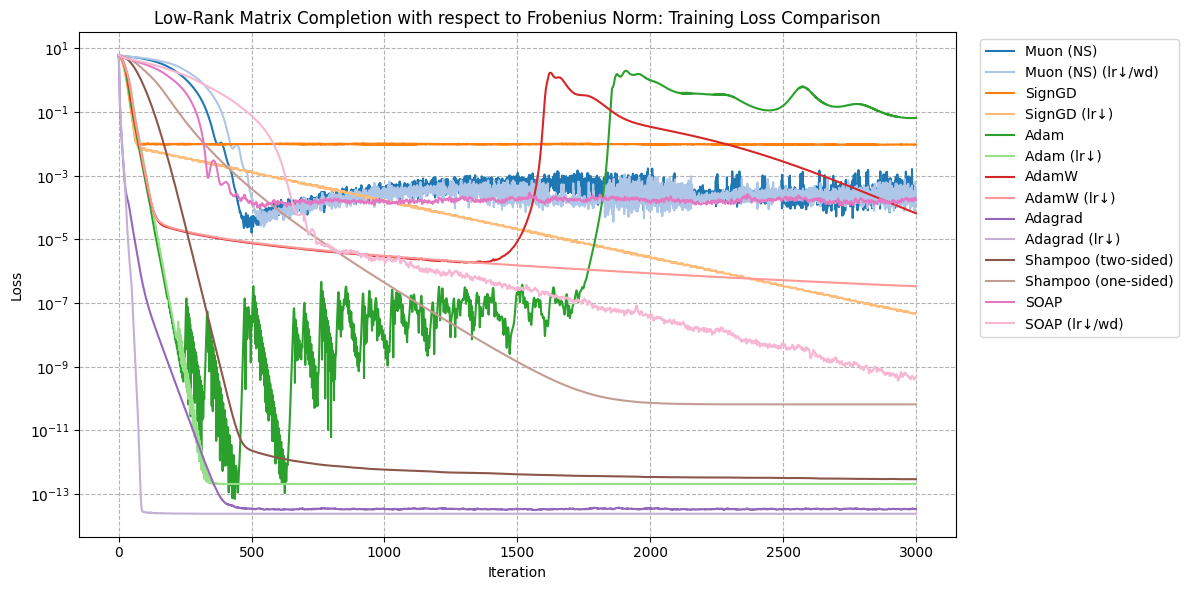

In [ ]:
plt.figure(figsize=(12, 6)) 
colors = plt.get_cmap('tab20').colors
cycler = cycle(colors)
plt.rc('axes', prop_cycle=(plt.cycler('color', colors)))
plt.semilogy(muon_losses_mc, label='Muon (NS)')
plt.semilogy(muon_losses_mc_decay, label='Muon (NS) (lr↓/wd)')
plt.semilogy(sgd_losses_mc, label='SignGD')
plt.semilogy(sgd_decay_losses_mc, label='SignGD (lr↓)')
plt.semilogy(adam_losses_mc, label='Adam')
plt.semilogy(adam_decay_losses_mc, label='Adam (lr↓)')
plt.semilogy(adamw_losses_mc, label='AdamW')
plt.semilogy(adamw_decay_losses_mc, label='AdamW (lr↓)')
plt.semilogy(adagrad_losses_mc, label='Adagrad')
plt.semilogy(adagrad_decay_losses_mc, label='Adagrad (lr↓)')
plt.semilogy(shampoo_losses_mc, label='Shampoo (two-sided)')
plt.semilogy(onesided_shampoo_losses_mc, label='Shampoo (one-sided)')
plt.semilogy(soap_losses_mc, label='SOAP')
plt.semilogy(soap_decay_losses_mc, label='SOAP (lr↓/wd)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Low-Rank Matrix Completion with respect to Frobenius Norm: Training Loss Comparison')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left') 
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.savefig('lowrank_matrix_completion_loss_comparison_2.png', bbox_inches='tight')
plt.show()

### Lowrank Matrix Completion Problem with respect to Nuclear Norm

In [ ]:
lowrank_mc_steps = 3000 # Specific steps for this benchmark

lr_muon = 5e-3
beta_muon = 0.95
lr_decay_muon = 0.98 # For Muon with LR decay
weight_decay_muon = 0.01

lr_adam = 1e-2
beta_adam = 0.9
lr_decay_adam = 0.98 # For Adam with LR decay

lr_adamW = 1e-2
beta_adamW = 0.9
lr_decay_adamW = 0.98 # For AdamW with LR decay
weight_decay_adamW = 0.01 # For Adam with weight decay

lr_adagrad = 1.0
beta_adagrad = 0.9 # Adagrad momentum (note: PyTorch's Adagrad doesn't have a direct momentum param)
lr_decay_adagrad = 0.95 # For Adagrad with LR decay
weight_decay_adagrad = 0.01 # For Adagrad with weight decay

lr_shampoo = 1.0
beta_shampoo = 0.9
lr_decay_shampoo = 0.95 # For Shampoo with LR decay
weight_decay_shampoo = 0.01

lr_sgd = 1e-2 # Learning rate for Sign Gradient Descent
lr_decay_sgd = 0.98 # For Sign Gradient Descent with LR decay

lr_soap = 3e-2
beta_soap_1 = 0.95
beta_soap_2 = 0.95
lr_decay_soap = 0.99 # For SOAP with LR decay
weight_decay_soap = 0.01

In [ ]:

# Muon (NS)
X_muon_mc, Y_muon_mc = get_XY0_lowrank_mc()
optimizer_muon_X_mc = SingleDeviceMuon([X_muon_mc], lr=lr_muon, momentum=beta_muon)
optimizer_muon_Y_mc = SingleDeviceMuon([Y_muon_mc], lr=lr_muon, momentum=beta_muon)
muon_losses_mc = []

print("\nRunning Muon for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    # Alternate optimization of X and Y
    optimizer_muon_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_muon_mc, Y_muon_mc, A_mask, M_star)
    loss.backward()
    optimizer_muon_X_mc.step()

    optimizer_muon_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_muon_mc, Y_muon_mc, A_mask, M_star) # Recalculate loss for Y's gradient
    loss.backward()
    optimizer_muon_Y_mc.step()

    muon_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Muon] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")

# Muon (NS) with LR decay and weight decay
X_muon_mc_decay, Y_muon_mc_decay = get_XY0_lowrank_mc()
optimizer_muon_X_mc_decay = SingleDeviceMuon([X_muon_mc_decay], lr=lr_muon, momentum=beta_muon, weight_decay=weight_decay_muon)
optimizer_muon_Y_mc_decay = SingleDeviceMuon([Y_muon_mc_decay], lr=lr_muon, momentum=beta_muon, weight_decay=weight_decay_muon)
muon_losses_mc_decay = []

print("\nRunning Muon (NS) with LR decay and weight decay for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_muon_X_mc_decay.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_muon_mc_decay, Y_muon_mc_decay, A_mask, M_star)
    loss.backward()
    optimizer_muon_X_mc_decay.step()

    optimizer_muon_Y_mc_decay.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_muon_mc_decay, Y_muon_mc_decay, A_mask, M_star)
    loss.backward()
    optimizer_muon_Y_mc_decay.step()

    muon_losses_mc_decay.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Muon lr↓/wd] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")

# Adam (fixed lr)
X_adam_mc, Y_adam_mc = get_XY0_lowrank_mc()
adam_losses_mc = []
optimizer_adam_X_mc = torch.optim.Adam([X_adam_mc], lr=lr_adam, betas=(beta_adam, 0.999), eps=1e-8)
optimizer_adam_Y_mc = torch.optim.Adam([Y_adam_mc], lr=lr_adam, betas=(beta_adam, 0.999), eps=1e-8)

print("\nRunning Adam for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adam_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adam_mc, Y_adam_mc, A_mask, M_star)
    loss.backward()
    optimizer_adam_X_mc.step()

    optimizer_adam_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adam_mc, Y_adam_mc, A_mask, M_star)
    loss.backward()
    optimizer_adam_Y_mc.step()

    adam_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adam] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")

# Adam (lr decay)
X_adam_decay_mc, Y_adam_decay_mc = get_XY0_lowrank_mc()
adam_decay_losses_mc = []
optimizer_adam_decay_X_mc = torch.optim.Adam([X_adam_decay_mc], lr=lr_adam, betas=(beta_adam, 0.999), eps=1e-8)
optimizer_adam_decay_Y_mc = torch.optim.Adam([Y_adam_decay_mc], lr=lr_adam, betas=(beta_adam, 0.999), eps=1e-8)
scheduler_X_mc = torch.optim.lr_scheduler.StepLR(optimizer_adam_decay_X_mc, step_size=25, gamma=lr_decay_adam)
scheduler_Y_mc = torch.optim.lr_scheduler.StepLR(optimizer_adam_decay_Y_mc, step_size=25, gamma=lr_decay_adam)

print("\nRunning Adam (lr decay) for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adam_decay_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adam_decay_mc, Y_adam_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adam_decay_X_mc.step()
    scheduler_X_mc.step()

    optimizer_adam_decay_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adam_decay_mc, Y_adam_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adam_decay_Y_mc.step()
    scheduler_Y_mc.step()

    adam_decay_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adam lr↓] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}, lr: {scheduler_X_mc.get_last_lr()[0]:.4e}")

# AdamW
X_adamw_mc, Y_adamw_mc = get_XY0_lowrank_mc()
adamw_losses_mc = []
optimizer_adamw_X_mc = torch.optim.AdamW([X_adamw_mc], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW, eps=1e-8)
optimizer_adamw_Y_mc = torch.optim.AdamW([Y_adamw_mc], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW, eps=1e-8)

print("\nRunning AdamW for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adamw_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adamw_mc, Y_adamw_mc, A_mask, M_star)
    loss.backward()
    optimizer_adamw_X_mc.step()

    optimizer_adamw_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adamw_mc, Y_adamw_mc, A_mask, M_star)
    loss.backward()
    optimizer_adamw_Y_mc.step()

    adamw_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[AdamW] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")

# AdamW (lr decay)
X_adamw_decay_mc, Y_adamw_decay_mc = get_XY0_lowrank_mc()
adamw_decay_losses_mc = []
optimizer_adamw_decay_X_mc = torch.optim.AdamW([X_adamw_decay_mc], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW, eps=1e-8)
optimizer_adamw_decay_Y_mc = torch.optim.AdamW([Y_adamw_decay_mc], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW, eps=1e-8)
scheduler_X_mc = torch.optim.lr_scheduler.StepLR(optimizer_adamw_decay_X_mc, step_size=25, gamma=lr_decay_adamW)
scheduler_Y_mc = torch.optim.lr_scheduler.StepLR(optimizer_adamw_decay_Y_mc, step_size=25, gamma=lr_decay_adamW)

print("\nRunning AdamW (lr decay) for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adamw_decay_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adamw_decay_mc, Y_adamw_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adamw_decay_X_mc.step()
    scheduler_X_mc.step()

    optimizer_adamw_decay_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adamw_decay_mc, Y_adamw_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adamw_decay_Y_mc.step()
    scheduler_Y_mc.step()

    adamw_decay_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[AdamW lr↓] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}, lr: {scheduler_X_mc.get_last_lr()[0]:.4e}")

# Sign Gradient Descent
X_sgd_mc, Y_sgd_mc = get_XY0_lowrank_mc()
optimizer_sgd_X_mc = SignGradientDescent([X_sgd_mc], lr=lr_sgd)
optimizer_sgd_Y_mc = SignGradientDescent([Y_sgd_mc], lr=lr_sgd)
sgd_losses_mc = []

print("\nRunning Sign Gradient Descent for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_sgd_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_sgd_mc, Y_sgd_mc, A_mask, M_star)
    loss.backward()
    optimizer_sgd_X_mc.step()

    optimizer_sgd_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_sgd_mc, Y_sgd_mc, A_mask, M_star)
    loss.backward()
    optimizer_sgd_Y_mc.step()

    sgd_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SGD] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")
        
# Sign Gradient Descent (lr decay)
X_sgd_decay_mc, Y_sgd_decay_mc = get_XY0_lowrank_mc()
optimizer_sgd_decay_X_mc = SignGradientDescent([X_sgd_decay_mc], lr=lr_sgd)
optimizer_sgd_decay_Y_mc = SignGradientDescent([Y_sgd_decay_mc], lr=lr_sgd)
scheduler_X_mc = torch.optim.lr_scheduler.StepLR(optimizer_sgd_decay_X_mc, step_size=25, gamma=lr_decay_sgd)
scheduler_Y_mc = torch.optim.lr_scheduler.StepLR(optimizer_sgd_decay_Y_mc, step_size=25, gamma=lr_decay_sgd)
sgd_decay_losses_mc = []

print("\nRunning Sign Gradient Descent (lr decay) for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_sgd_decay_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_sgd_decay_mc, Y_sgd_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_sgd_decay_X_mc.step()
    scheduler_X_mc.step()

    optimizer_sgd_decay_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_sgd_decay_mc, Y_sgd_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_sgd_decay_Y_mc.step()
    scheduler_Y_mc.step()

    sgd_decay_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SGD lr↓] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}, lr: {scheduler_X_mc.get_last_lr()[0]:.4e}")

# Adagrad
X_adagrad_mc, Y_adagrad_mc = get_XY0_lowrank_mc()
optimizer_adagrad_X_mc = torch.optim.Adagrad([X_adagrad_mc], lr=lr_adagrad, eps=1e-8) # Added eps for stability
optimizer_adagrad_Y_mc = torch.optim.Adagrad([Y_adagrad_mc], lr=lr_adagrad, eps=1e-8) # Added eps for stability
adagrad_losses_mc = []

print("\nRunning Adagrad for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adagrad_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adagrad_mc, Y_adagrad_mc, A_mask, M_star)
    loss.backward()
    optimizer_adagrad_X_mc.step()

    optimizer_adagrad_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adagrad_mc, Y_adagrad_mc, A_mask, M_star)
    loss.backward()
    optimizer_adagrad_Y_mc.step()

    adagrad_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adagrad] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")
        
# Adagrad (lr decay)
X_adagrad_decay_mc, Y_adagrad_decay_mc = get_XY0_lowrank_mc()
optimizer_adagrad_decay_X_mc = torch.optim.Adagrad([X_adagrad_decay_mc], lr=lr_adagrad, eps=1e-8) # Added eps for stability
optimizer_adagrad_decay_Y_mc = torch.optim.Adagrad([Y_adagrad_decay_mc], lr=lr_adagrad, eps=1e-8) # Added eps for stability
scheduler_X_mc = torch.optim.lr_scheduler.StepLR(optimizer_adagrad_decay_X_mc, step_size=25, gamma=lr_decay_adagrad)
scheduler_Y_mc = torch.optim.lr_scheduler.StepLR(optimizer_adagrad_decay_Y_mc, step_size=25, gamma=lr_decay_adagrad)
adagrad_decay_losses_mc = []

print("\nRunning Adagrad (lr decay) for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_adagrad_decay_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adagrad_decay_mc, Y_adagrad_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adagrad_decay_X_mc.step()
    scheduler_X_mc.step()

    optimizer_adagrad_decay_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_adagrad_decay_mc, Y_adagrad_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_adagrad_decay_Y_mc.step()
    scheduler_Y_mc.step()

    adagrad_decay_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adagrad lr↓] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}, lr: {scheduler_X_mc.get_last_lr()[0]:.4e}")
        
# Two-sided Shampoo
X_shampoo_mc, Y_shampoo_mc = get_XY0_lowrank_mc()
optimizer_shampoo_X_mc = Shampoo([X_shampoo_mc], lr=lr_shampoo, momentum=beta_shampoo)
optimizer_shampoo_Y_mc = Shampoo([Y_shampoo_mc], lr=lr_shampoo, momentum=beta_shampoo)
shampoo_losses_mc = []

print("\nRunning Shampoo for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_shampoo_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_shampoo_mc, Y_shampoo_mc, A_mask, M_star)
    loss.backward()
    optimizer_shampoo_X_mc.step()

    optimizer_shampoo_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_shampoo_mc, Y_shampoo_mc, A_mask, M_star)
    loss.backward()
    optimizer_shampoo_Y_mc.step()

    shampoo_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Shampoo] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")
        
# One-sided Shampoo
X_onesided_shampoo_mc, Y_onesided_shampoo_mc = get_XY0_lowrank_mc()
optimizer_onesided_shampoo_X_mc = OneSidedShampoo([X_onesided_shampoo_mc], lr=lr_shampoo, momentum=beta_shampoo)
optimizer_onesided_shampoo_Y_mc = OneSidedShampoo([Y_onesided_shampoo_mc], lr=lr_shampoo, momentum=beta_shampoo)
onesided_shampoo_losses_mc = []

print("\nRunning One-sided Shampoo for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_onesided_shampoo_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_onesided_shampoo_mc, Y_onesided_shampoo_mc, A_mask, M_star)
    loss.backward()
    optimizer_onesided_shampoo_X_mc.step()

    optimizer_onesided_shampoo_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_onesided_shampoo_mc, Y_onesided_shampoo_mc, A_mask, M_star)
    loss.backward()
    optimizer_onesided_shampoo_Y_mc.step()

    onesided_shampoo_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[One-sided Shampoo] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")

# SOAP
X_soap_mc, Y_soap_mc = get_XY0_lowrank_mc()
optimizer_soap_X_mc = SOAP([X_soap_mc], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=0.01)
optimizer_soap_Y_mc = SOAP([Y_soap_mc], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=0.01)
soap_losses_mc = []

print("\nRunning SOAP for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_soap_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_soap_mc, Y_soap_mc, A_mask, M_star)
    loss.backward()
    optimizer_soap_X_mc.step()

    optimizer_soap_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_soap_mc, Y_soap_mc, A_mask, M_star)
    loss.backward()
    optimizer_soap_Y_mc.step()

    soap_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SOAP] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}")
        
# SOAP (lr decay)
X_soap_decay_mc, Y_soap_decay_mc = get_XY0_lowrank_mc()
optimizer_soap_decay_X_mc = SOAP([X_soap_decay_mc], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=0.01)
optimizer_soap_decay_Y_mc = SOAP([Y_soap_decay_mc], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=0.01)
scheduler_X_mc = torch.optim.lr_scheduler.StepLR(optimizer_soap_decay_X_mc, step_size=25, gamma=lr_decay_soap)
scheduler_Y_mc = torch.optim.lr_scheduler.StepLR(optimizer_soap_decay_Y_mc, step_size=25, gamma=lr_decay_soap)
soap_decay_losses_mc = []

print("\nRunning SOAP (lr decay) for Low-Rank Matrix Completion...")
for step in range(lowrank_mc_steps):
    optimizer_soap_decay_X_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_soap_decay_mc, Y_soap_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_soap_decay_X_mc.step()
    scheduler_X_mc.step()

    optimizer_soap_decay_Y_mc.zero_grad()
    loss = lowrank_matrix_completion_loss_with_nuc_norm(X_soap_decay_mc, Y_soap_decay_mc, A_mask, M_star)
    loss.backward()
    optimizer_soap_decay_Y_mc.step()
    scheduler_Y_mc.step()

    soap_decay_losses_mc.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SOAP lr↓] Step {step+1}/{lowrank_mc_steps}, Loss: {loss.item():.4e}, lr: {scheduler_X_mc.get_last_lr()[0]:.4e}")


Running Muon for Low-Rank Matrix Completion...
[Muon] Step 100/3000, Loss: 4.7665e+00
[Muon] Step 200/3000, Loss: 4.1880e+00
[Muon] Step 300/3000, Loss: 3.2990e+00
[Muon] Step 400/3000, Loss: 2.1291e+00
[Muon] Step 500/3000, Loss: 9.9740e-01
[Muon] Step 600/3000, Loss: 2.7052e-01
[Muon] Step 700/3000, Loss: 2.2868e-02
[Muon] Step 800/3000, Loss: 5.1246e-04
[Muon] Step 900/3000, Loss: 2.4178e-05
[Muon] Step 1000/3000, Loss: 2.6881e-05
[Muon] Step 1100/3000, Loss: 2.6749e-05
[Muon] Step 1200/3000, Loss: 5.0990e-05
[Muon] Step 1300/3000, Loss: 4.1611e-05
[Muon] Step 1400/3000, Loss: 1.0453e-04
[Muon] Step 1500/3000, Loss: 2.2724e-04
[Muon] Step 1600/3000, Loss: 4.0254e-04
[Muon] Step 1700/3000, Loss: 5.0087e-04
[Muon] Step 1800/3000, Loss: 5.0684e-04
[Muon] Step 1900/3000, Loss: 7.0612e-04
[Muon] Step 2000/3000, Loss: 7.8441e-04
[Muon] Step 2100/3000, Loss: 8.9374e-04
[Muon] Step 2200/3000, Loss: 7.0175e-04
[Muon] Step 2300/3000, Loss: 2.1221e-04
[Muon] Step 2400/3000, Loss: 2.0638e-05
[

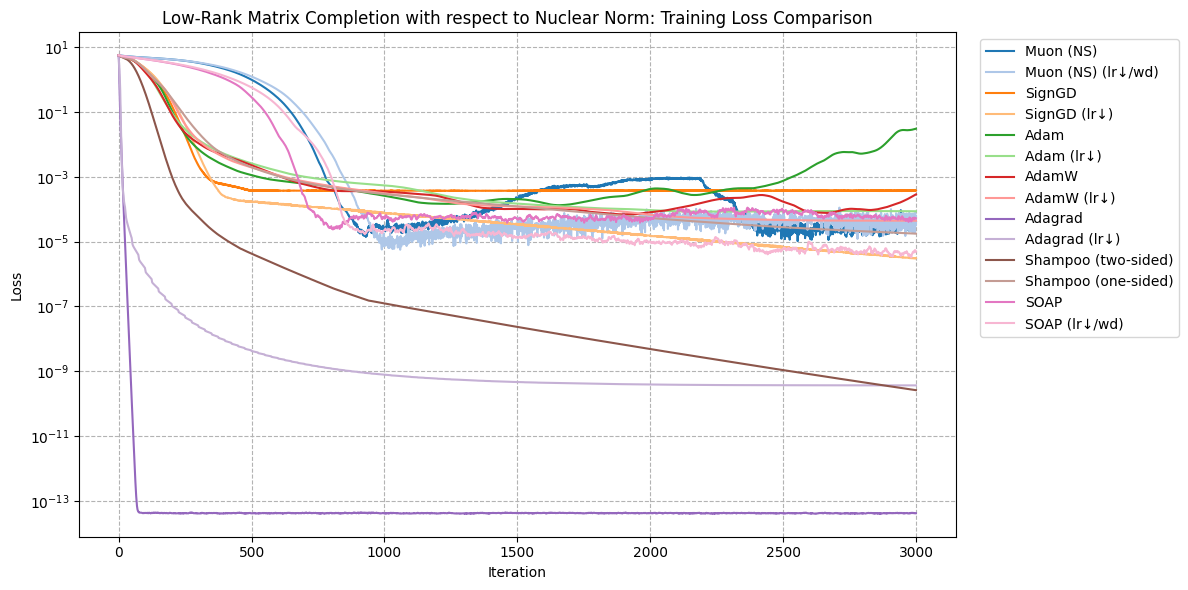

In [ ]:
plt.figure(figsize=(12, 6)) 
colors = plt.get_cmap('tab20').colors
cycler = cycle(colors)
plt.rc('axes', prop_cycle=(plt.cycler('color', colors)))
plt.semilogy(muon_losses_mc, label='Muon (NS)')
plt.semilogy(muon_losses_mc_decay, label='Muon (NS) (lr↓/wd)')
plt.semilogy(sgd_losses_mc, label='SignGD')
plt.semilogy(sgd_decay_losses_mc, label='SignGD (lr↓)')
plt.semilogy(adam_losses_mc, label='Adam')
plt.semilogy(adam_decay_losses_mc, label='Adam (lr↓)')
plt.semilogy(adamw_losses_mc, label='AdamW')
plt.semilogy(adamw_decay_losses_mc, label='AdamW (lr↓)')
plt.semilogy(adagrad_losses_mc, label='Adagrad')
plt.semilogy(adagrad_decay_losses_mc, label='Adagrad (lr↓)')
plt.semilogy(shampoo_losses_mc, label='Shampoo (two-sided)')
plt.semilogy(onesided_shampoo_losses_mc, label='Shampoo (one-sided)')
plt.semilogy(soap_losses_mc, label='SOAP')
plt.semilogy(soap_decay_losses_mc, label='SOAP (lr↓/wd)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Low-Rank Matrix Completion with respect to Nuclear Norm: Training Loss Comparison')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left') 
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.savefig('lowrank_matrix_completion_with_nuc_norm_loss_comparison_2.png', bbox_inches='tight')
plt.show()

## Matrix Quadratic Regression


In [ ]:
lr_muon = 1e-2
beta_muon = 0.95
lr_decay_muon = 0.99 # For Muon with LR decay
weight_decay_muon = 0.01

lr_adam = 5e-3
beta_adam = 0.9
lr_decay_adam = 0.99 # For Adam with LR decay

lr_adamW = 5e-3
beta_adamW = 0.9
lr_decay_adamW = 0.99 # For AdamW with LR decay
weight_decay_adamW = 0.01 # For Adam with weight decay

lr_adagrad = 0.1
beta_adagrad = 0.9 # Adagrad momentum (note: PyTorch's Adagrad doesn't have a direct momentum param)
lr_decay_adagrad = 0.99 # For Adagrad with LR decay
weight_decay_adagrad = 0.01 # For Adagrad with weight decay

lr_shampoo = 0.5
beta_shampoo = 0.9
lr_decay_shampoo = 0.99 # For Shampoo with LR decay
weight_decay_shampoo = 0.01

lr_sgd = 1e-2 # Learning rate for Sign Gradient Descent
lr_decay_sgd = 0.99 # For Sign Gradient Descent with LR decay

lr_soap = 5e-2
beta_soap_1 = 0.95
beta_soap_2 = 0.95
lr_decay_soap = 0.99 # For SOAP with LR decay
weight_decay_soap = 0.01

In [ ]:
p, m, n, q = 1000, 500, 100, 250 # Dimensions from original MQR test
matrix_qr_steps = 4000 # Specific steps for this benchmark

# Initialize A, B, C as standard Gaussian
A = torch.randn(p, m, device=device)
B = torch.randn(n, q, device=device)
C = torch.randn(p, q, device=device)

def get_X0_matrix_qr():
    return (2 * torch.rand(m, n, device=device) - 1).requires_grad_()


# Muon (NS)
X_muon_mqr = get_X0_matrix_qr()
optimizer_muon_mqr = SingleDeviceMuon([X_muon_mqr], lr=lr_muon, momentum=beta_muon)
muon_losses_mqr = []

print("Running Muon for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_muon_mqr.zero_grad()
    loss = matrix_quadratic_regression_loss(X_muon_mqr, A, B, C)
    loss.backward()
    optimizer_muon_mqr.step()
    muon_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Muon] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}")
        
# Muon (NS) with LR decay and weight decay
X_muon_mqr_decay = get_X0_matrix_qr()
optimizer_muon_mqr_decay = SingleDeviceMuon([X_muon_mqr_decay], lr=lr_muon, momentum=beta_muon, weight_decay=weight_decay_muon)
scheduler_muon_mqr_decay = torch.optim.lr_scheduler.StepLR(optimizer_muon_mqr_decay, step_size=25, gamma=lr_decay_muon)
muon_losses_mqr_decay = []

print("\nRunning Muon (NS) with LR decay and weight decay for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_muon_mqr_decay.zero_grad()
    loss = matrix_quadratic_regression_loss(X_muon_mqr_decay, A, B, C)
    loss.backward()
    optimizer_muon_mqr_decay.step()
    scheduler_muon_mqr_decay.step()
    muon_losses_mqr_decay.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Muon lr↓/wd] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}, lr: {scheduler_muon_mqr_decay.get_last_lr()[0]:.4e}")
        
# Adam (fixed lr)
X_adam_mqr = get_X0_matrix_qr()
adam_losses_mqr = []
optimizer_adam_mqr = torch.optim.Adam([X_adam_mqr], lr=lr_adam, betas=(beta_adam, 0.999), eps=1e-8)

print("\nRunning Adam for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_adam_mqr.zero_grad()
    loss = matrix_quadratic_regression_loss(X_adam_mqr, A, B, C)
    loss.backward()
    optimizer_adam_mqr.step()
    adam_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adam] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}")

# Adam (lr decay)
X_adam_decay_mqr = get_X0_matrix_qr()
adam_decay_losses_mqr = []
optimizer_adam_decay_mqr = torch.optim.Adam([X_adam_decay_mqr], lr=lr_adam, betas=(beta_adam, 0.999), eps=1e-8)
scheduler_mqr = torch.optim.lr_scheduler.StepLR(optimizer_adam_decay_mqr, step_size=25, gamma=lr_decay_adam)

print("\nRunning Adam (lr decay) for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_adam_decay_mqr.zero_grad()
    loss = matrix_quadratic_regression_loss(X_adam_decay_mqr, A, B, C)
    loss.backward()
    optimizer_adam_decay_mqr.step()
    scheduler_mqr.step()
    adam_decay_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adam lr↓] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}, lr: {scheduler_mqr.get_last_lr()[0]:.4e}")
        
# AdamW
X_adamw_mqr = get_X0_matrix_qr()
adamw_losses_mqr = []
optimizer_adamw_mqr = torch.optim.AdamW([X_adamw_mqr], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW, eps=1e-8)

print("\nRunning AdamW for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_adamw_mqr.zero_grad()
    loss = matrix_quadratic_regression_loss(X_adamw_mqr, A, B, C)
    loss.backward()
    optimizer_adamw_mqr.step()
    adamw_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[AdamW] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}")
        
# AdamW (lr decay)
X_adamw_decay_mqr = get_X0_matrix_qr()
adamw_decay_losses_mqr = []
optimizer_adamw_decay_mqr = torch.optim.AdamW([X_adamw_decay_mqr], lr=lr_adamW, betas=(beta_adamW, 0.999), weight_decay=weight_decay_adamW, eps=1e-8)
scheduler_mqr = torch.optim.lr_scheduler.StepLR(optimizer_adamw_decay_mqr, step_size=25, gamma=lr_decay_adamW)

print("\nRunning AdamW (lr decay) for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_adamw_decay_mqr.zero_grad()
    loss = matrix_quadratic_regression_loss(X_adamw_decay_mqr, A, B, C)
    loss.backward()
    optimizer_adamw_decay_mqr.step()
    scheduler_mqr.step()
    adamw_decay_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[AdamW lr↓] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}, lr: {scheduler_mqr.get_last_lr()[0]:.4e}")

# Newton Method (from original test, for comparison)
X_newton_mqr = get_X0_matrix_qr()
newton_losses_mqr = []
lr_newton = 0.25

print("\nRunning Newton Method for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    X_newton_mqr.requires_grad_(True)
    loss = matrix_quadratic_regression_loss(X_newton_mqr, A, B, C)
    grad = torch.autograd.grad(loss, X_newton_mqr, create_graph=True)[0]
    with torch.no_grad():
        AtA = A.t() @ A
        BtB = B @ B.t()
        G = grad
        try:
            U1, S1, _ = torch.linalg.svd(AtA)
            U2, S2, _ = torch.linalg.svd(BtB)
            G_tilde = U1.t() @ G @ U2
            Delta = G_tilde / (S1[:, None] * S2[None, :] + 1e-8)
            Delta = U1 @ Delta @ U2.t()
        except Exception as e:
            Delta = G # Fallback to gradient if SVD fails
        X_newton_mqr = X_newton_mqr - lr_newton * Delta
    newton_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Newton] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}")

# Adagrad
X_adagrad_mqr = get_X0_matrix_qr()
optimizer_adagrad_mqr = torch.optim.Adagrad([X_adagrad_mqr], lr=lr_adagrad, eps=1e-8) # Added eps for stability
adagrad_losses_mqr = []

print("\nRunning Adagrad for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_adagrad_mqr.zero_grad()
    loss = matrix_quadratic_regression_loss(X_adagrad_mqr, A, B, C)
    loss.backward()
    optimizer_adagrad_mqr.step()
    adagrad_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adagrad] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}")

# Adagrad (lr decay)
X_adagrad_decay_mqr = get_X0_matrix_qr()
optimizer_adagrad_decay_mqr = torch.optim.Adagrad([X_adagrad_decay_mqr], lr=lr_adagrad, eps=1e-8) # Added eps for stability
scheduler_mqr = torch.optim.lr_scheduler.StepLR(optimizer_adagrad_decay_mqr, step_size=25, gamma=lr_decay_adagrad)
adagrad_decay_losses_mqr = []

print("\nRunning Adagrad (lr decay) for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_adagrad_decay_mqr.zero_grad()
    loss = matrix_quadratic_regression_loss(X_adagrad_decay_mqr, A, B, C)
    loss.backward()
    optimizer_adagrad_decay_mqr.step()
    scheduler_mqr.step()
    adagrad_decay_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Adagrad lr↓] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}, lr: {scheduler_mqr.get_last_lr()[0]:.4e}")

# Two-sided Shampoo
X_shampoo_mqr = get_X0_matrix_qr()
optimizer_shampoo_mqr = Shampoo([X_shampoo_mqr], lr=lr_shampoo, momentum=beta_shampoo)
shampoo_losses_mqr = []

print("\nRunning Shampoo for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_shampoo_mqr.zero_grad()
    loss = matrix_quadratic_regression_loss(X_shampoo_mqr, A, B, C)
    loss.backward()
    optimizer_shampoo_mqr.step()
    shampoo_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[Shampoo] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}")
        
# One-sided Shampoo
X_onesided_shampoo_mqr = get_X0_matrix_qr()
optimizer_onesided_shampoo_mqr = OneSidedShampoo([X_onesided_shampoo_mqr], lr=lr_shampoo, momentum=beta_shampoo)
onesided_shampoo_losses_mqr = []

print("\nRunning One-sided Shampoo for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_onesided_shampoo_mqr.zero_grad()
    loss = matrix_quadratic_regression_loss(X_onesided_shampoo_mqr, A, B, C)
    loss.backward()
    optimizer_onesided_shampoo_mqr.step()
    onesided_shampoo_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[One-sided Shampoo] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}")

# Sign Gradient Descent
X_sgd_mqr = get_X0_matrix_qr()
optimizer_sgd_mqr = SignGradientDescent([X_sgd_mqr], lr=lr_sgd)
sgd_losses_mqr = []

print("\nRunning Sign Gradient Descent for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_sgd_mqr.zero_grad()
    loss = matrix_quadratic_regression_loss(X_sgd_mqr, A, B, C)
    loss.backward()
    optimizer_sgd_mqr.step()
    sgd_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SGD] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}")
        
# Sign Gradient Descent (lr decay)
X_sgd_mqr_decay = get_X0_matrix_qr()
optimizer_sgd_mqr_decay = SignGradientDescent([X_sgd_mqr_decay], lr=lr_sgd)
scheduler_sgd_mqr_decay = torch.optim.lr_scheduler.StepLR(optimizer_sgd_mqr_decay, step_size=25, gamma=lr_decay_sgd)
sgd_losses_mqr_decay = []

print("\nRunning Sign Gradient Descent (lr decay) for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_sgd_mqr_decay.zero_grad()
    loss = matrix_quadratic_regression_loss(X_sgd_mqr_decay, A, B, C)
    loss.backward()
    optimizer_sgd_mqr_decay.step()
    scheduler_sgd_mqr_decay.step()
    sgd_losses_mqr_decay.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SGD lr↓] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}, lr: {scheduler_sgd_mqr_decay.get_last_lr()[0]:.4e}")
        
# Soup
X_soap_mqr = get_X0_matrix_qr()
optimizer_soap_mqr = SOAP([X_soap_mqr], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=weight_decay_soap)
soap_losses_mqr = []

print("\nRunning SOAP for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_soap_mqr.zero_grad()
    loss = matrix_quadratic_regression_loss(X_soap_mqr, A, B, C)
    loss.backward()
    optimizer_soap_mqr.step()
    soap_losses_mqr.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SOAP] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}")
        
# SOAP (lr decay)
X_soap_mqr_decay = get_X0_matrix_qr()
optimizer_soap_mqr_decay = SOAP([X_soap_mqr_decay], lr=lr_soap, betas=(beta_soap_1, beta_soap_2), weight_decay=weight_decay_soap)
scheduler_soap_mqr_decay = torch.optim.lr_scheduler.StepLR(optimizer_soap_mqr_decay, step_size=25, gamma=lr_decay_soap)
soap_losses_mqr_decay = []

print("\nRunning SOAP (lr decay) for Matrix Quadratic Regression...")
for step in range(matrix_qr_steps):
    optimizer_soap_mqr_decay.zero_grad()
    loss = matrix_quadratic_regression_loss(X_soap_mqr_decay, A, B, C)
    loss.backward()
    optimizer_soap_mqr_decay.step()
    scheduler_soap_mqr_decay.step()
    soap_losses_mqr_decay.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"[SOAP lr↓] Step {step+1}/{matrix_qr_steps}, Loss: {loss.item():.4e}, lr: {scheduler_soap_mqr_decay.get_last_lr()[0]:.4e}")

Running Muon for Matrix Quadratic Regression...
[Muon] Step 100/4000, Loss: 1.4697e+09
[Muon] Step 200/4000, Loss: 9.7544e+08
[Muon] Step 300/4000, Loss: 6.2074e+08
[Muon] Step 400/4000, Loss: 3.7484e+08
[Muon] Step 500/4000, Loss: 2.0964e+08
[Muon] Step 600/4000, Loss: 1.0615e+08
[Muon] Step 700/4000, Loss: 4.7176e+07
[Muon] Step 800/4000, Loss: 1.8018e+07
[Muon] Step 900/4000, Loss: 5.6706e+06
[Muon] Step 1000/4000, Loss: 1.3728e+06
[Muon] Step 1100/4000, Loss: 2.4895e+05
[Muon] Step 1200/4000, Loss: 1.0811e+05
[Muon] Step 1300/4000, Loss: 1.0371e+05
[Muon] Step 1400/4000, Loss: 1.0358e+05
[Muon] Step 1500/4000, Loss: 1.0337e+05
[Muon] Step 1600/4000, Loss: 1.0349e+05
[Muon] Step 1700/4000, Loss: 1.0354e+05
[Muon] Step 1800/4000, Loss: 1.0353e+05
[Muon] Step 1900/4000, Loss: 1.0349e+05
[Muon] Step 2000/4000, Loss: 1.0355e+05
[Muon] Step 2100/4000, Loss: 1.0365e+05
[Muon] Step 2200/4000, Loss: 1.0346e+05
[Muon] Step 2300/4000, Loss: 1.0335e+05
[Muon] Step 2400/4000, Loss: 1.0349e+05
[

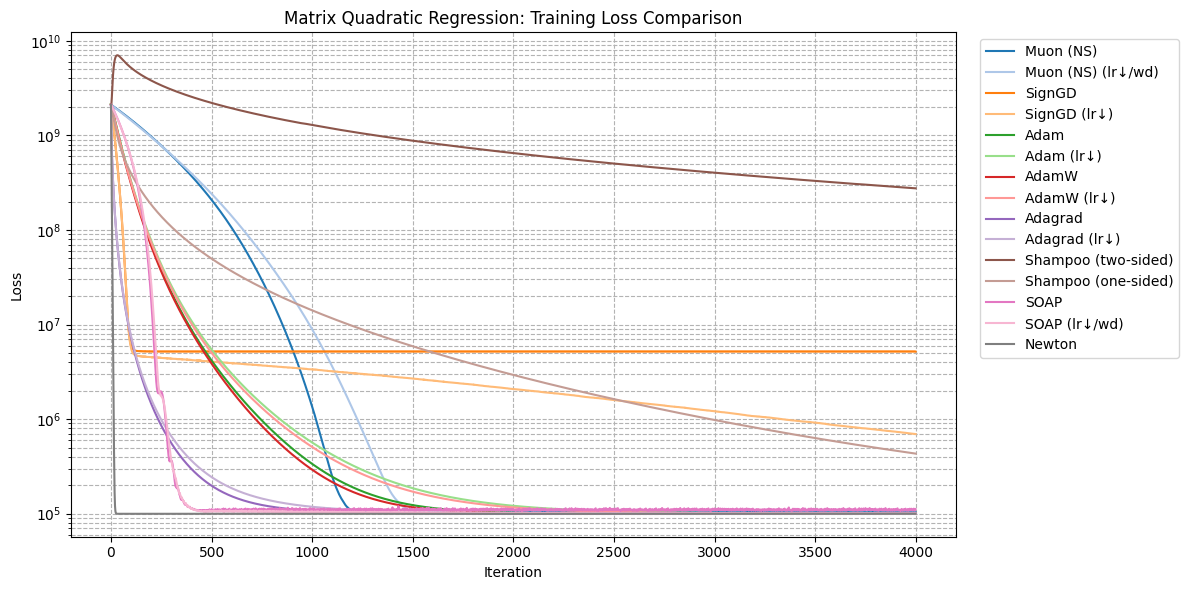

In [ ]:
plt.figure(figsize=(12, 6)) 
colors = plt.get_cmap('tab20').colors
cycler = cycle(colors)
plt.rc('axes', prop_cycle=(plt.cycler('color', colors)))
plt.semilogy(muon_losses_mqr, label='Muon (NS)')
plt.semilogy(muon_losses_mqr_decay, label='Muon (NS) (lr↓/wd)')
plt.semilogy(sgd_losses_mqr, label='SignGD')
plt.semilogy(sgd_losses_mqr_decay, label='SignGD (lr↓)')
plt.semilogy(adam_losses_mqr, label='Adam')
plt.semilogy(adam_decay_losses_mqr, label='Adam (lr↓)')
plt.semilogy(adamw_losses_mqr, label='AdamW')
plt.semilogy(adamw_decay_losses_mqr, label='AdamW (lr↓)')
plt.semilogy(adagrad_losses_mqr, label='Adagrad')
plt.semilogy(adagrad_decay_losses_mqr, label='Adagrad (lr↓)')
plt.semilogy(shampoo_losses_mqr, label='Shampoo (two-sided)')
plt.semilogy(onesided_shampoo_losses_mqr, label='Shampoo (one-sided)')
plt.semilogy(soap_losses_mqr, label='SOAP')
plt.semilogy(soap_losses_mqr_decay, label='SOAP (lr↓/wd)')
plt.semilogy(newton_losses_mqr, label='Newton')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Matrix Quadratic Regression: Training Loss Comparison')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left') 
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.savefig('matrix_quadratic_regression_loss_comparison_2.png', bbox_inches='tight')
plt.show()